In [1]:
#QFT Audio Frequency Finder
#Jacob Hammond

In [2]:
#Libraries
import numpy as np
import math
from numpy import pi
import scipy.io
from scipy.io import wavfile as wav
from scipy.fftpack import fft
from pydub import AudioSegment
import matplotlib.pyplot as plt
from qiskit import QuantumCircuit, QuantumRegister, transpile, assemble, Aer
from qiskit.tools.monitor import job_monitor
from qiskit.visualization import plot_histogram, plot_bloch_multivector

/Users/hammondjacob/opt/anaconda3/envs/quantum/lib/python3.9/site-packages/pydub/utils.py:170: RuntimeWarning: Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work
  warn("Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work", RuntimeWarning)


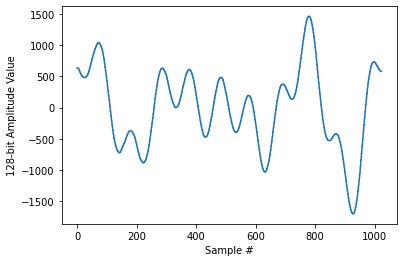

In [5]:
#Turn wav audio file into samples
n_qubits = 10 #number of qubits that will be used to encode samples
audio = AudioSegment.from_file('f_chord.wav')
audio.set_frame_rate(2000)
frame_rate = audio.frame_rate
samples = audio.get_array_of_samples()[2048:2**n_qubits+2048]
#Plot Samples
plt.xlabel('Sample #')
plt.ylabel('128-bit Amplitude Value')
plt.plot(list(range(len(samples))), samples)

In [6]:
#Encodes a normalized set of amplitudes from the audio samples onto the states of the qubits 
def create_encoded_qc(samples):
    amplitudes = len(samples)
    num_qubits = int(math.log2(amplitudes))
    
    q = QuantumRegister(num_qubits)
    qc = QuantumCircuit(q)
    
    normalized_amplitudes = samples / np.linalg.norm(samples)
    
    qc.initialize(normalized_amplitudes, [q[i] for i in range(num_qubits)])
    
    return qc

In [7]:
#Create Quantum Circuit
audio_qc = create_encoded_qc(samples)

In [8]:
#QFT function definitions from Qiskit
def qft_rotations(circuit, n):
    if n == 0: # Exit function if circuit is empty
        return circuit
    n -= 1 # Indexes start from 0
    circuit.h(n) # Apply the H-gate to the most significant qubit
    for qubit in range(n):
        # For each less significant qubit, we need to do a
        # smaller-angled controlled rotation: 
        circuit.cp(pi/2**(n-qubit), qubit, n)
    # At the end of our function, we call the same function again on
    # the next qubits (we reduced n by one earlier in the function)
    qft_rotations(circuit, n)
    
def swap_registers(circuit, n):
    for qubit in range(n//2):
        circuit.swap(qubit, n-qubit-1)
    return circuit

def qft(circuit, n):
    """QFT on the first n qubits in circuit"""
    qft_rotations(circuit, n)
    swap_registers(circuit, n)
    return circuit

def get_qft_counts(counts, n_qubits):

    out = []
    keys = counts.keys()
    for i in range(2**n_qubits):
        id = get_bit_string(i, n_qubits)
        if(id in keys):
            out.append(counts[id])
        else:
            out.append(0)

    return out

def get_bit_string(n, n_qubits):
    bs = "{0:b}".format(n)
    bs = "0"*(n_qubits - len(bs)) + bs

    return bs

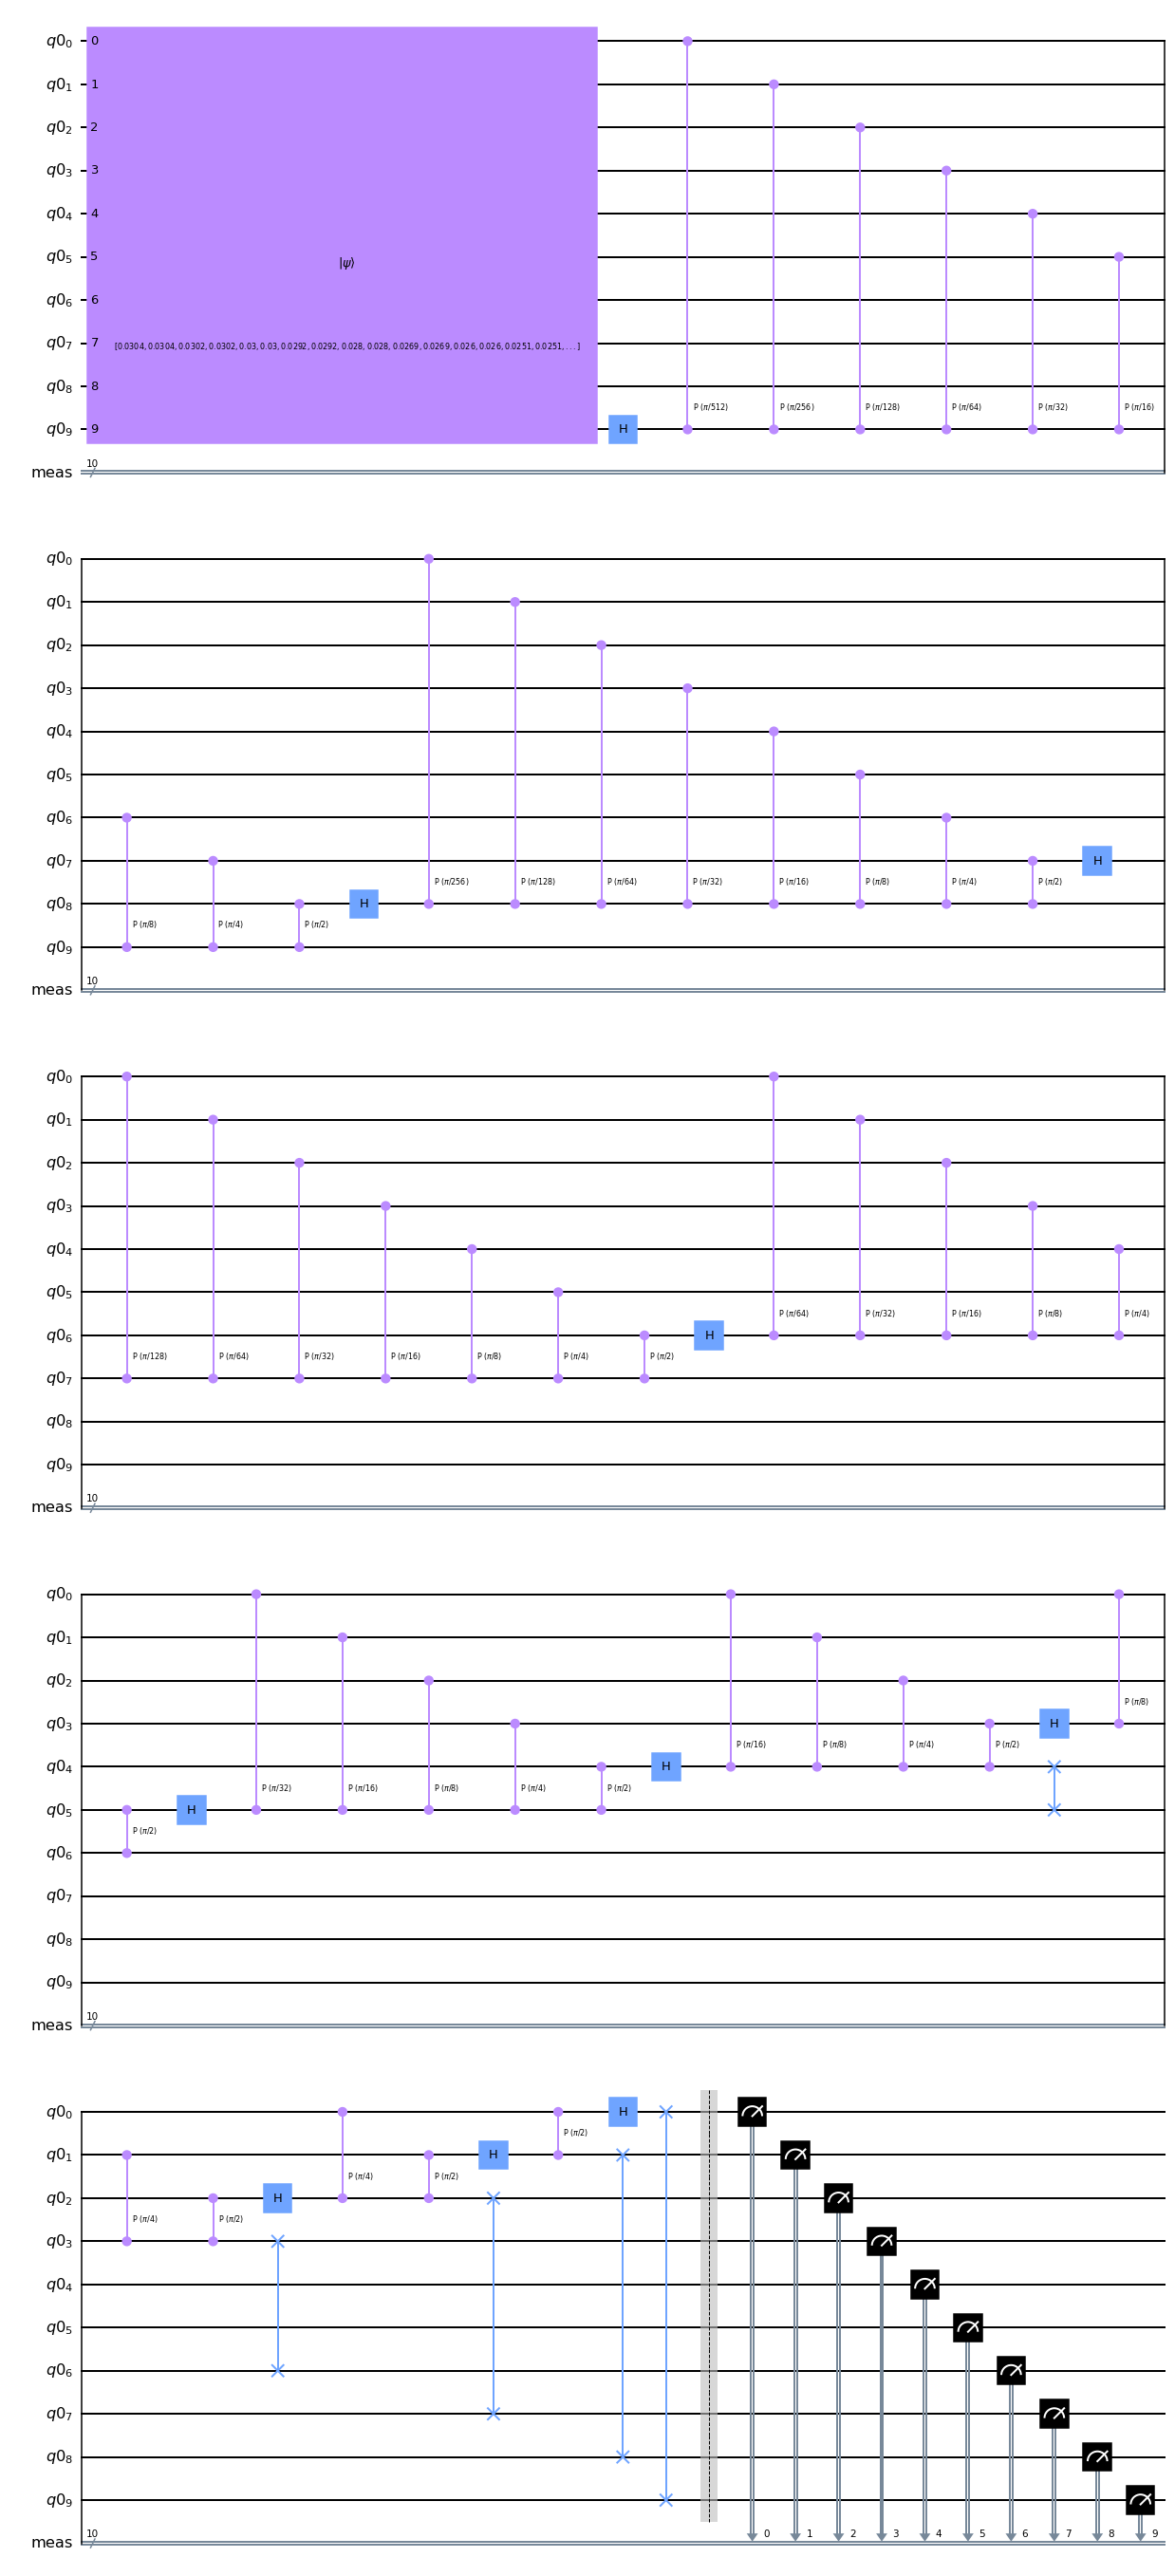

In [9]:
#Apply QFT to quantum circuit, create measurement register, and draw visualization of circuit
qft(audio_qc, n_qubits)
audio_qc.measure_all()
audio_qc.draw(output='mpl')

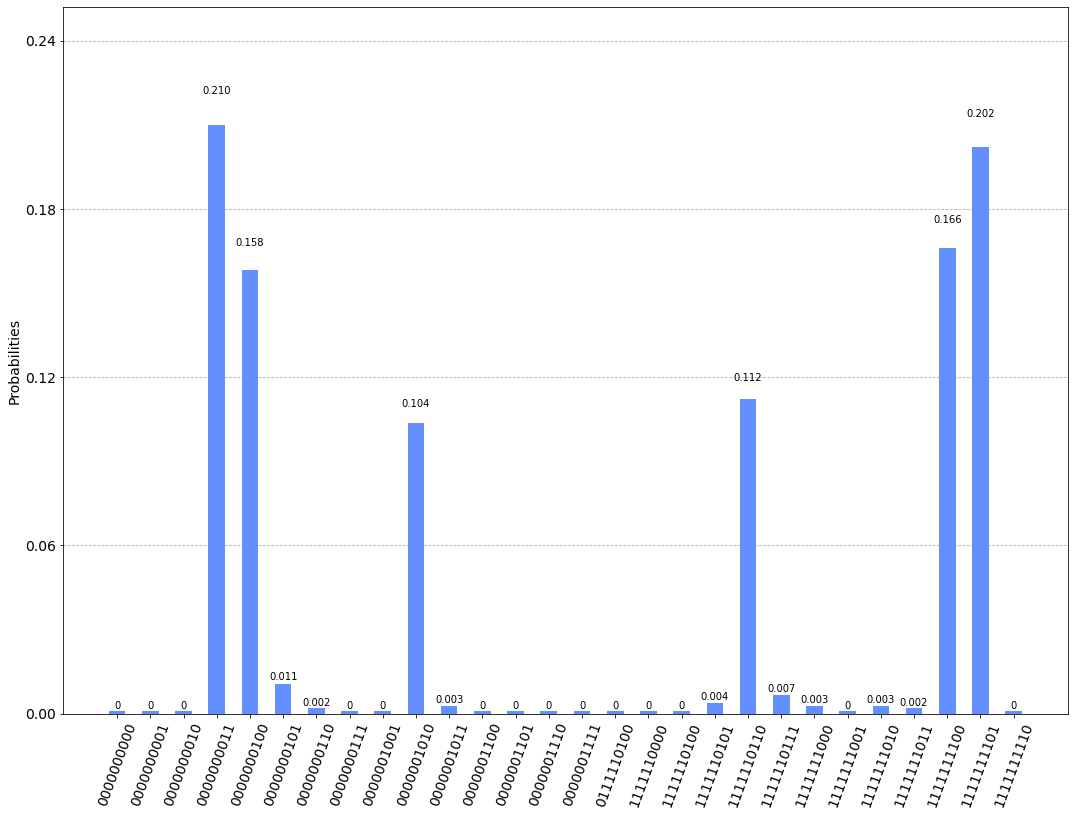

In [10]:
#Simulation
sim = Aer.get_backend("aer_simulator")
qobj = assemble(audio_qc)
counts = sim.run(qobj).result().get_counts()
qft_counts = get_qft_counts(counts, n_qubits)[:len(samples)//2]
plot_histogram(counts, figsize=(18, 13))

In [11]:
 #Calculate Frequencies and print top 2 frequencies
top_indices = np.argsort(-np.array(qft_counts))
freqs = top_indices*frame_rate/2**n_qubits
print(freqs[:3])

[129.19921875 172.265625   430.6640625 ]


In [22]:
#IMBQ Setup
from qiskit import IBMQ, execute
IBMQ.enable_account('token')
provider = IBMQ.get_provider(hub='ibm-q')
from qiskit.providers.ibmq import least_busy
small_devices = provider.backends(filters=lambda x: x.configuration().n_qubits ==5
                                   and not x.configuration().simulator)
least_busy(small_devices)

<IBMQBackend('ibmq_belem') from IBMQ(hub='ibm-q', group='open', project='main')>

In [24]:
#Program on Real Quantum Hardware
backend = provider.get_backend('ibmq_belem')
q_counts = execute(audio_qc, backend, shots=8192).result().get_counts()

In [48]:
#Plot Results
ibmq_counts = get_qft_counts(q_counts, n_qubits)[:len(samples)//2]
plot_histogram(q_counts,figsize=(18, 13), filename='ibmq_440_histogram.png')

In [ ]:
#Obtain Frequency
qtop_indices = np.argsort(-np.array(ibmq_counts))
freqs = qtop_indices*frame_rate/2**n_qubits
print(freqs[:3])